In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc

%matplotlib inline

In [2]:
# create long representation for file and cust
#march = pd.read_hdf('../march.h5', 'df')
#march = march.groupby(['file_id','customer_id']).count().reset_index()[['file_id','customer_id','timestamp']]

#april = pd.read_hdf('../april.h5', 'df')
#april = april.groupby(['file_id','customer_id']).count().reset_index()[['file_id','customer_id','timestamp']]

#may = pd.read_hdf('../may.h5', 'df')
#may = may.groupby(['file_id','customer_id']).count().reset_index()[['file_id','customer_id','timestamp']]

#data = pd.concat([march,april,may],axis=0)

#data = data.groupby(['file_id','customer_id']).count().reset_index()[['file_id','customer_id']]
#data.head(3)

In [2]:
#data.to_hdf('file_cust_longrep.h5','df')
data = pd.read_hdf('file_cust_longrep.h5', 'df')
data.head(3)

,file_id,customer_id
0,00008c73ee43c15b16c26b26398c1577,033e91e730e176cd2ac81dc48a8f5088
1,00008c73ee43c15b16c26b26398c1577,06bea9f9c1d72c4d3151efa6bcd5ba83
2,00008c73ee43c15b16c26b26398c1577,113597f904c023f44d1a01babb780f58


In [3]:
file_df = pd.read_csv('file_df.csv')
file_df = file_df[['file_id','first_day']]

data = pd.merge(data,file_df,on='file_id',how='left')

train = pd.read_csv('training-set.csv',header=None)
test = pd.read_csv('testing-set.csv',header=None)
train.columns = ['file_id','target']
test.columns = ['file_id','target']

# full mean code
#fullmeancode = pd.read_csv('final/forfullmeancode.csv')
#train = pd.concat([train,fullmeancode],axis=0)
# full mean code

data = pd.merge(data,train,how='left',on='file_id')
data = data.sort_values(by=['first_day','file_id']).reset_index(drop=True)
data.head(3)

,file_id,customer_id,first_day,target
0,0087304d5bee451f0d82c7407b0fa7d1,282396145a3df4452761bacf8049f6db,1,0.0
1,0087304d5bee451f0d82c7407b0fa7d1,501782bb051c5368f641f5299e550f32,1,0.0
2,0087304d5bee451f0d82c7407b0fa7d1,54a57555a85251b45a9de37ba95a4cf3,1,0.0


In [4]:
tr_data = data[data['first_day']<62] # 62 for predict, 50 for val
tr_data = tr_data[['file_id','customer_id','target']]
tr_data.head(3)

,file_id,customer_id,target
0,0087304d5bee451f0d82c7407b0fa7d1,282396145a3df4452761bacf8049f6db,0.0
1,0087304d5bee451f0d82c7407b0fa7d1,501782bb051c5368f641f5299e550f32,0.0
2,0087304d5bee451f0d82c7407b0fa7d1,54a57555a85251b45a9de37ba95a4cf3,0.0


In [5]:
cumsum = tr_data.groupby('customer_id').cumsum().target - tr_data['target']
cumcnt = tr_data.groupby('customer_id').cumcount()
tr_data['mean_score'] = cumsum / cumcnt

In [6]:
tr_data['mean_score'].mean()

0.006771791991959975

In [7]:
alpha = 20
gbmean = 0.006764493003441334

tr_data['mean_score'] = ((tr_data['mean_score']*cumcnt)+(gbmean*alpha))/(cumcnt+alpha)

In [9]:
customer_score = tr_data.groupby('customer_id').last().reset_index()[['customer_id','mean_score']]
customer_score.head(3)

,customer_id,mean_score
0,00000145d9062eada528bace5fb4864e,NaN
1,000003d77bee692d83b7b83fdba60d3d,0.003146
2,00000aea7887eaf96dbd022025e426fd,NaN


In [10]:
customer_df = pd.read_csv('rs_customer_df.csv')
customer_df = pd.merge(customer_df,customer_score,how='left',on='customer_id')
customer_df = customer_df[['customer_id','mean_score']]
customer_df.head(3)

,customer_id,mean_score
0,0000006fa286976bf35ea17f1f19bc7a,NaN
1,00000145d9062eada528bace5fb4864e,NaN
2,000003d77bee692d83b7b83fdba60d3d,0.003146


In [11]:
#customer_df.loc[pd.isnull(customer_df).mean_score,'mean_score']=0.012656403967587571
customer_df = customer_df[customer_df['mean_score']>-1]
customer_df.shape

(2529078, 2)

In [12]:
te_data = data[data['first_day']>49]
te_data.head(3)

,file_id,customer_id,day_cnt,first_day,target
35808799,0021c7f072ad0e8068ab8c611700bfe1,00546d10281534af9f1bcbb14dca53d6,1,50,0.0
35808800,0021c7f072ad0e8068ab8c611700bfe1,04a890cd36f3cface3faeea2fc06967b,1,50,0.0
35808801,0021c7f072ad0e8068ab8c611700bfe1,052c7bc0c271b8f1accb80ca2bda46db,1,50,0.0


In [13]:
te_data = te_data.sort_values(by=['first_day','file_id']).reset_index(drop=True)
te_data = te_data[['file_id','customer_id']]
te_data = pd.merge(te_data,customer_df,how='left',on='customer_id')
te_data.head(3)

,file_id,customer_id,mean_score
0,0021c7f072ad0e8068ab8c611700bfe1,00546d10281534af9f1bcbb14dca53d6,NaN
1,0021c7f072ad0e8068ab8c611700bfe1,04a890cd36f3cface3faeea2fc06967b,0.004665
2,0021c7f072ad0e8068ab8c611700bfe1,052c7bc0c271b8f1accb80ca2bda46db,0.005203


In [14]:
data = pd.concat([tr_data,te_data],ignore_index=True)
data = data[data['mean_score']>-1]
data.head(3)

,customer_id,file_id,mean_score,target
455,282396145a3df4452761bacf8049f6db,00a0fadf6f4b4d244459b3bc8f6ee7fa,0.006442,0.0
467,282396145a3df4452761bacf8049f6db,00a885e87beb6fb1f6ca6ee9eb783779,0.006150,0.0
528,282396145a3df4452761bacf8049f6db,00a92b584bfcf58b70d5e965e91da03c,0.005882,0.0


In [15]:
data = data[['file_id','mean_score']]
data.head(3)

,file_id,mean_score
455,00a0fadf6f4b4d244459b3bc8f6ee7fa,0.006442
467,00a885e87beb6fb1f6ca6ee9eb783779,0.006150
528,00a92b584bfcf58b70d5e965e91da03c,0.005882


In [16]:
data['lgms'] = np.log(data['mean_score'])

(array([   325945.,   3055299.,   9000149.,  20461295.,  16288895.,
           176044.,    305008.,    171824.,    119113.,    155312.]),
 array([-8.82796493, -7.95308883, -7.07821274, -6.20333665, -5.32846056,
        -4.45358447, -3.57870838, -2.70383229, -1.8289562 , -0.95408011,
        -0.07920402]),
 <a list of 10 Patch objects>)

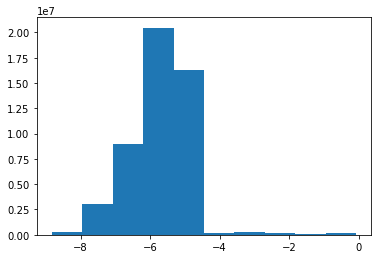

In [17]:
plt.hist(data['lgms'] )

In [18]:
data.loc[ (data['lgms']<-8.03148033), 'lgms_cat']=0
data.loc[ (data['lgms']>=-8.03148033)&(data['lgms']<-7.14789407), 'lgms_cat']=1
data.loc[ (data['lgms']>=-7.14789407)&(data['lgms']<-6.26430781), 'lgms_cat']=2
data.loc[ (data['lgms']>=-6.26430781)&(data['lgms']<-5.38072156), 'lgms_cat']=3
data.loc[ (data['lgms']>=-5.38072156)&(data['lgms']<-4.4971353), 'lgms_cat']=4
data.loc[ (data['lgms']>=-4.4971353), 'lgms_cat']=5

In [19]:
data = data[['file_id','lgms_cat']]

In [20]:
cat0 = data[data['lgms_cat']==0].groupby('file_id').count().reset_index()
cat0.columns = ['file_id','cat0cnt']

cat1 = data[data['lgms_cat']==1].groupby('file_id').count().reset_index()
cat1.columns = ['file_id','cat1cnt']

cat2 = data[data['lgms_cat']==2].groupby('file_id').count().reset_index()
cat2.columns = ['file_id','cat2cnt']

cat3 = data[data['lgms_cat']==3].groupby('file_id').count().reset_index()
cat3.columns = ['file_id','cat3cnt']

cat4 = data[data['lgms_cat']==4].groupby('file_id').count().reset_index()
cat4.columns = ['file_id','cat4cnt']

cat5 = data[data['lgms_cat']==5].groupby('file_id').count().reset_index()
cat5.columns = ['file_id','cat5cnt']

In [21]:
data = data.groupby('file_id').count().reset_index()
data.columns = ['file_id','cust_cnt']
data=pd.merge(data,cat0,how='left',on='file_id')
data=pd.merge(data,cat1,how='left',on='file_id')
data=pd.merge(data,cat2,how='left',on='file_id')
data=pd.merge(data,cat3,how='left',on='file_id')
data=pd.merge(data,cat4,how='left',on='file_id')
data=pd.merge(data,cat5,how='left',on='file_id')
data.head(3)

,file_id,cust_cnt,cat0cnt,cat1cnt,cat2cnt,cat3cnt,cat4cnt,cat5cnt
0,00008c73ee43c15b16c26b26398c1577,33,NaN,NaN,NaN,NaN,32.0,1.0
1,0000e2398b12121a85166fed5fe2a3da,1,NaN,NaN,NaN,NaN,1.0,NaN
2,0001fe8dce14ce099aa6ca8ea5026ea7,154,NaN,4.0,4.0,35.0,111.0,NaN


In [22]:
data.fillna(0,inplace=True)
data.head(3)

,file_id,cust_cnt,cat0cnt,cat1cnt,cat2cnt,cat3cnt,cat4cnt,cat5cnt
0,00008c73ee43c15b16c26b26398c1577,33,0.0,0.0,0.0,0.0,32.0,1.0
1,0000e2398b12121a85166fed5fe2a3da,1,0.0,0.0,0.0,0.0,1.0,0.0
2,0001fe8dce14ce099aa6ca8ea5026ea7,154,0.0,4.0,4.0,35.0,111.0,0.0


In [23]:
data['cat0cnt'] = (data['cat0cnt']/data['cust_cnt'])*100
data['cat1cnt'] = (data['cat1cnt']/data['cust_cnt'])*100
data['cat2cnt'] = (data['cat2cnt']/data['cust_cnt'])*100
data['cat3cnt'] = (data['cat3cnt']/data['cust_cnt'])*100
data['cat4cnt'] = (data['cat4cnt']/data['cust_cnt'])*100
data['cat5cnt'] = (data['cat5cnt']/data['cust_cnt'])*100
data.drop('cust_cnt',axis=1,inplace=True)

In [24]:
data.shape

(79077, 7)

In [25]:
data.to_csv('caticnt_val.csv',index=False)